In [1]:
import numpy as np
import torch
import pyepo

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.1424
0 -> 10 -> 15 -> 8 -> 5 -> 3 -> 17 -> 1 -> 6 -> 13 -> 19 -> 11 -> 18 -> 7 -> 2 -> 14 -> 12 -> 4 -> 9 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.34it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 128.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.13it/s]


In [6]:
from dataset import optDatasetConstrs
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.99it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-1, num_epochs+1)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
lr = 5e-2
num_epochs = 40
log_step = 2

In [11]:
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(42)
    torch.manual_seed(42)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    # init log
    loss_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # early stop
            if stopper.stop(regret_val):
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass)
            loss = forward_func(data, reg, loss_func)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # regret
    regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
    regret_log_trn.append(regret_trn)
    regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
    regret_log_val.append(regret_val)
    tbar.write("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, loss.item(), regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                    loader_train_cost, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:09<?, ?it/s]

Epoch   0, Train Regret: 198.6788%, Val Regret: 207.9420%


Epoch    1, Loss:  29.6491:   5%|██▊                                                    | 2/40 [00:22<03:26,  5.44s/it]

Epoch   2, Train Regret:  21.5747%, Val Regret:  22.6237%


Epoch    3, Loss:  10.7441:  10%|█████▌                                                 | 4/40 [00:33<03:04,  5.13s/it]

Epoch   4, Train Regret:  19.3306%, Val Regret:  19.4696%


Epoch    5, Loss:  11.5103:  15%|████████▎                                              | 6/40 [00:45<02:50,  5.02s/it]

Epoch   6, Train Regret:  16.5899%, Val Regret:  17.0301%


Epoch    7, Loss:   7.2818:  20%|███████████                                            | 8/40 [00:57<02:39,  4.99s/it]

Epoch   8, Train Regret:  14.7507%, Val Regret:  15.3860%


Epoch    9, Loss:   9.6682:  25%|█████████████▌                                        | 10/40 [01:09<02:30,  5.02s/it]

Epoch  10, Train Regret:  13.5019%, Val Regret:  14.3579%


Epoch   11, Loss:   8.1706:  30%|████████████████▏                                     | 12/40 [01:21<02:22,  5.08s/it]

Epoch  12, Train Regret:  13.2402%, Val Regret:  13.5024%


Epoch   13, Loss:   8.5581:  35%|██████████████████▉                                   | 14/40 [01:33<02:17,  5.28s/it]

Epoch  14, Train Regret:  13.2328%, Val Regret:  13.5786%


Epoch   15, Loss:   6.2377:  40%|█████████████████████▌                                | 16/40 [01:45<02:03,  5.14s/it]

Epoch  16, Train Regret:  13.2110%, Val Regret:  13.6528%


Epoch   17, Loss:   7.3810:  45%|████████████████████████▎                             | 18/40 [01:56<02:22,  6.49s/it]


Epoch  18, Train Regret:  13.1624%, Val Regret:  13.5988%
Early Stop!
Epoch  18, Loss:   7.3810, Train Regret:  13.1624%, Val Regret:  13.5988%

Evaluation:
Test Regret: 13.4669%
Training Elapsed Time: 2.52 Sec


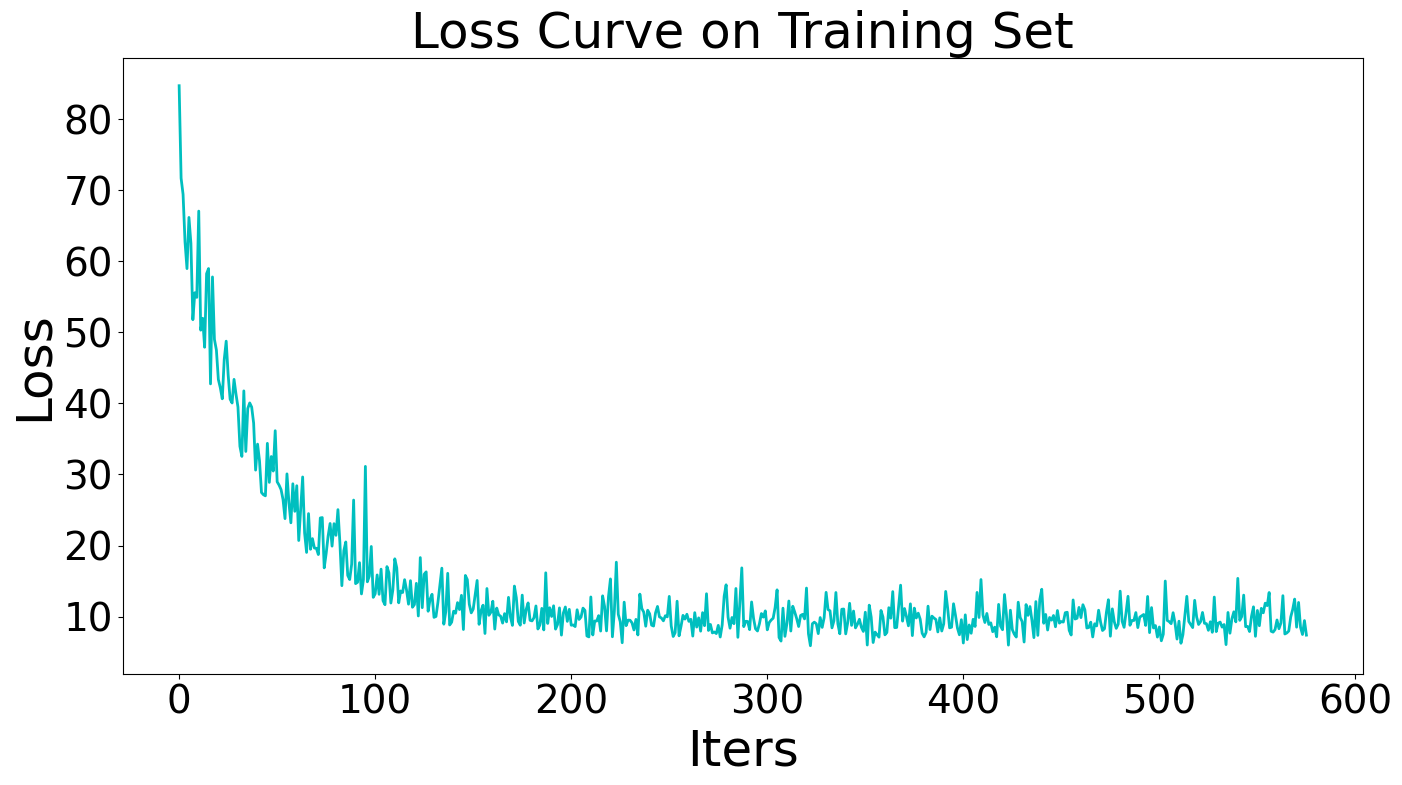

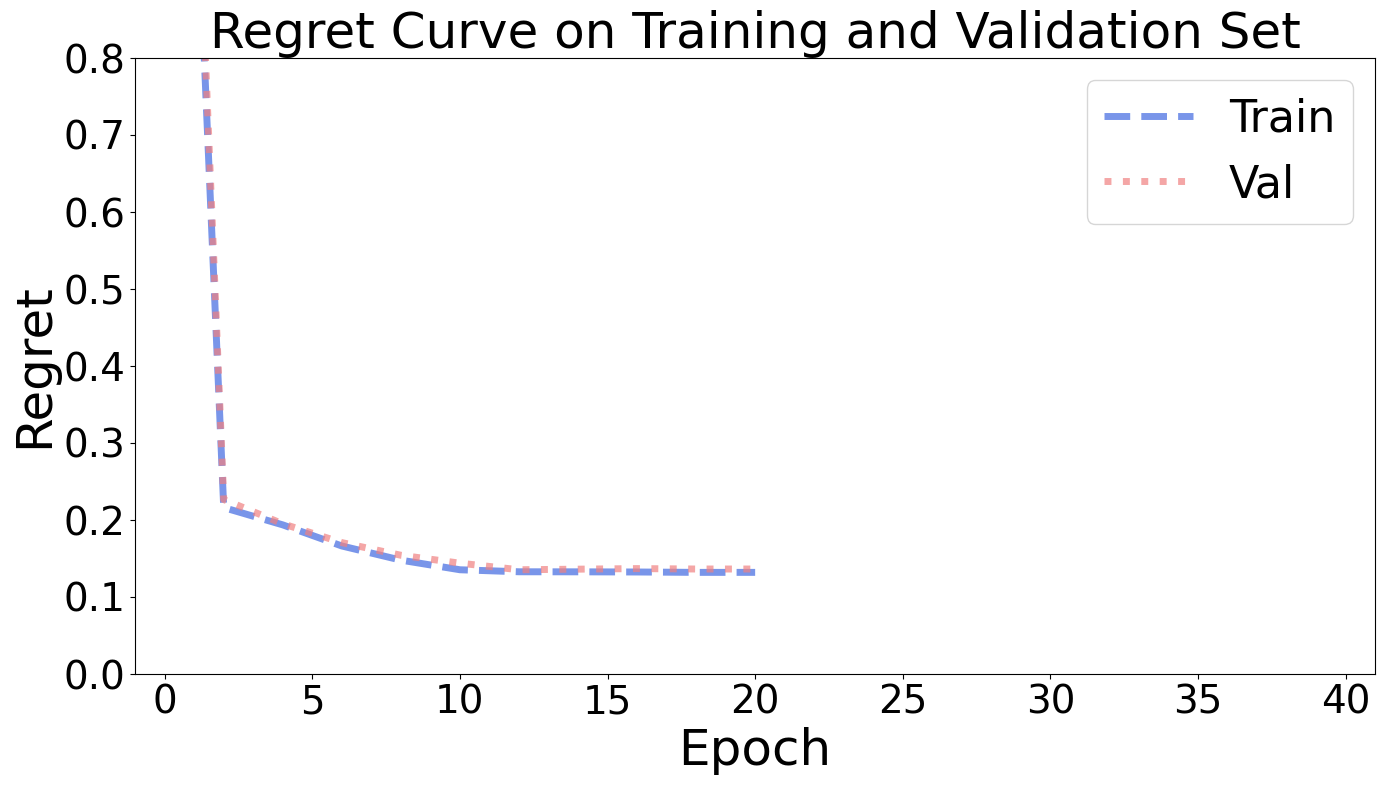

In [15]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method 

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, processes=8)

Num of cores: 8


In [18]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:09<?, ?it/s]

Epoch   0, Train Regret: 186.8612%, Val Regret: 186.3438%


Epoch    1, Loss:  -0.9991:   5%|██▊                                                    | 2/40 [00:34<06:53, 10.89s/it]

Epoch   2, Train Regret:   8.0392%, Val Regret:   8.8811%


Epoch    3, Loss:  -0.9992:  10%|█████▌                                                 | 4/40 [00:56<06:05, 10.15s/it]

Epoch   4, Train Regret:   7.2503%, Val Regret:   7.5068%


Epoch    5, Loss:  -0.9994:  15%|████████▎                                              | 6/40 [01:18<05:46, 10.18s/it]

Epoch   6, Train Regret:   6.8536%, Val Regret:   7.3319%


Epoch    7, Loss:  -0.9993:  20%|███████████                                            | 8/40 [01:40<05:22, 10.09s/it]

Epoch   8, Train Regret:   6.8322%, Val Regret:   7.5104%


Epoch    9, Loss:  -0.9992:  25%|█████████████▌                                        | 10/40 [02:01<05:00, 10.03s/it]

Epoch  10, Train Regret:   6.9537%, Val Regret:   6.9189%


Epoch   11, Loss:  -0.9993:  30%|████████████████▏                                     | 12/40 [02:23<04:37,  9.92s/it]

Epoch  12, Train Regret:   6.8549%, Val Regret:   6.8520%


Epoch   13, Loss:  -0.9998:  35%|██████████████████▉                                   | 14/40 [02:44<04:18,  9.95s/it]

Epoch  14, Train Regret:   6.9622%, Val Regret:   7.3750%


Epoch   15, Loss:  -0.9998:  40%|█████████████████████▌                                | 16/40 [03:07<03:58,  9.94s/it]

Epoch  16, Train Regret:   7.1277%, Val Regret:   7.6689%


Epoch   17, Loss:  -0.9998:  45%|████████████████████████▎                             | 18/40 [03:29<04:15, 11.63s/it]


Epoch  18, Train Regret:   7.1201%, Val Regret:   7.5802%
Early Stop!
Epoch  18, Loss:  -0.9998, Train Regret:   7.1201%, Val Regret:   7.5802%

Evaluation:
Test Regret: 7.8522%
Training Elapsed Time: 87.47 Sec


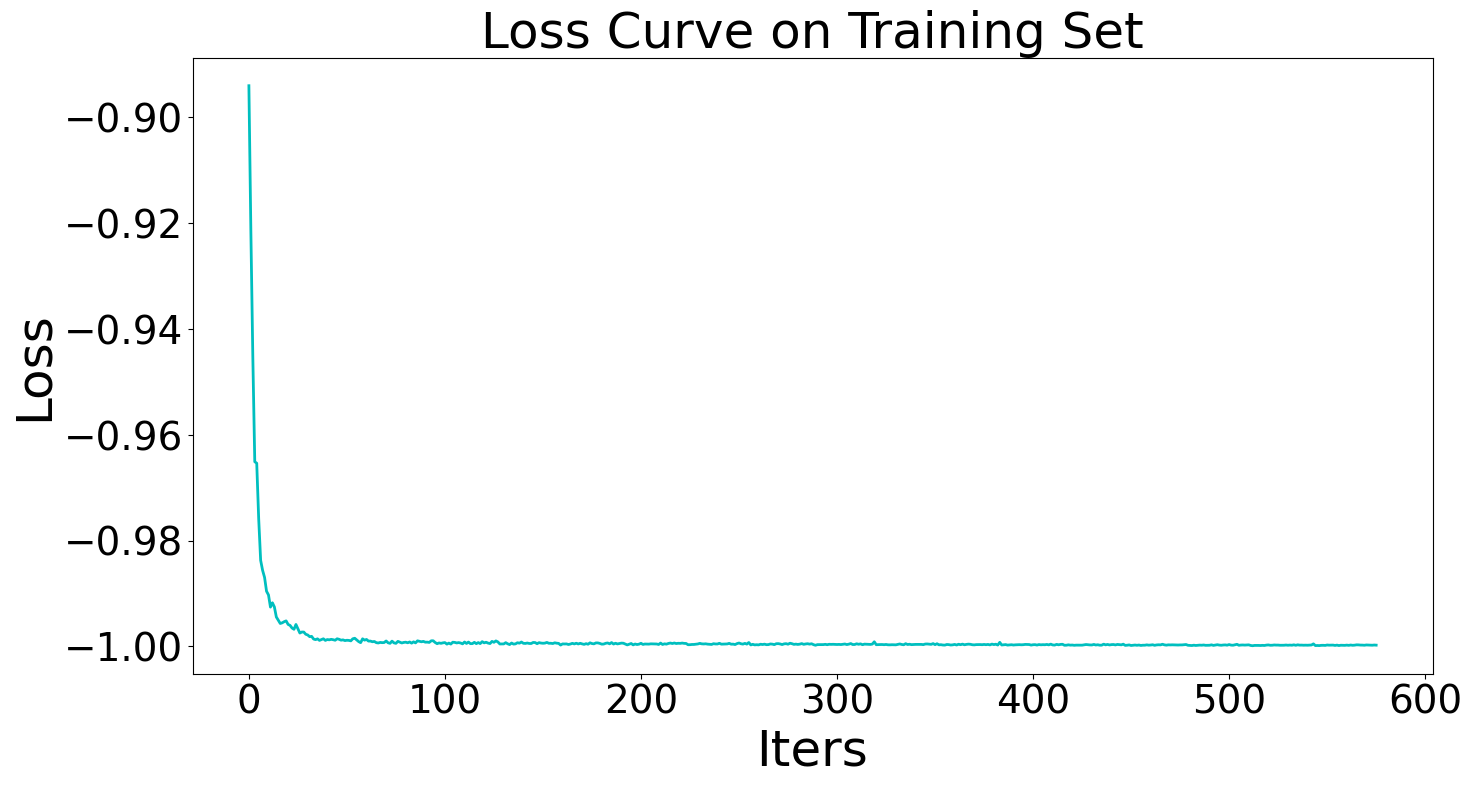

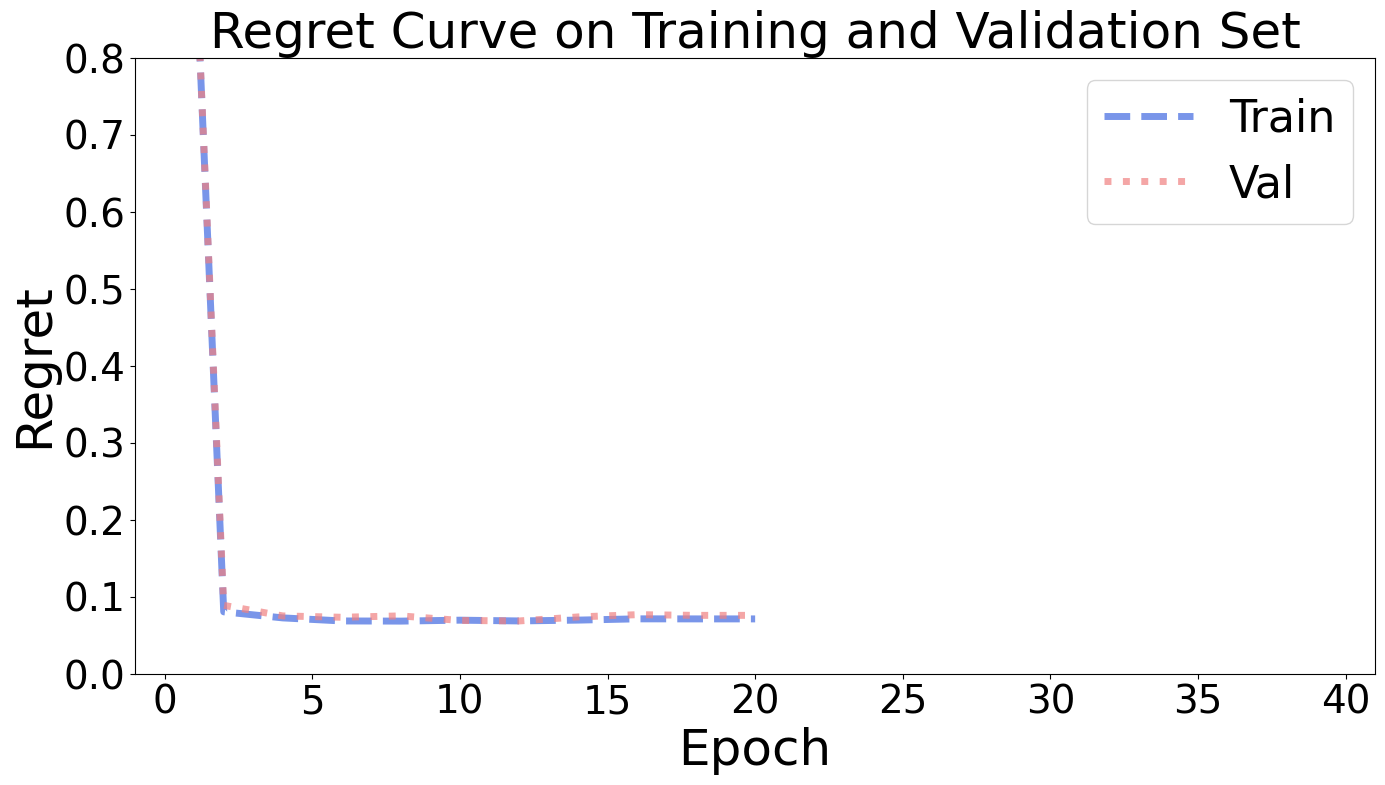

In [19]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NNLS Method 

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import nnlsConeAlignedCosine
# init loss
ca_cos = nnlsConeAlignedCosine(optmodel, processes=8)

Num of cores: 8


In [22]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:09<?, ?it/s]

Epoch   0, Train Regret: 186.8612%, Val Regret: 186.3438%


Epoch    1, Loss:  -0.9991:   5%|██▊                                                    | 2/40 [00:26<04:44,  7.48s/it]

Epoch   2, Train Regret:   8.0392%, Val Regret:   8.8811%


Epoch    3, Loss:  -0.9992:  10%|█████▌                                                 | 4/40 [00:44<04:36,  7.69s/it]

Epoch   4, Train Regret:   7.2503%, Val Regret:   7.5068%


Epoch    5, Loss:  -0.9994:  15%|████████▎                                              | 6/40 [01:01<04:24,  7.79s/it]

Epoch   6, Train Regret:   6.8536%, Val Regret:   7.3319%


Epoch    7, Loss:  -0.9993:  20%|███████████                                            | 8/40 [01:21<04:11,  7.85s/it]

Epoch   8, Train Regret:   6.8322%, Val Regret:   7.5104%


Epoch    9, Loss:  -0.9992:  25%|█████████████▌                                        | 10/40 [01:38<04:05,  8.20s/it]

Epoch  10, Train Regret:   6.9537%, Val Regret:   6.9189%


Epoch   11, Loss:  -0.9993:  30%|████████████████▏                                     | 12/40 [01:56<03:42,  7.96s/it]

Epoch  12, Train Regret:   6.8549%, Val Regret:   6.8520%


Epoch   13, Loss:  -0.9998:  35%|██████████████████▉                                   | 14/40 [02:13<03:23,  7.84s/it]

Epoch  14, Train Regret:   6.9622%, Val Regret:   7.3750%


Epoch   15, Loss:  -0.9998:  40%|█████████████████████▌                                | 16/40 [02:30<03:05,  7.72s/it]

Epoch  16, Train Regret:   7.1277%, Val Regret:   7.6689%


Epoch   17, Loss:  -0.9998:  45%|████████████████████████▎                             | 18/40 [02:47<03:24,  9.29s/it]


Epoch  18, Train Regret:   7.1216%, Val Regret:   7.5802%
Early Stop!
Epoch  18, Loss:  -0.9998, Train Regret:   7.1216%, Val Regret:   7.5802%

Evaluation:
Test Regret: 7.8522%
Training Elapsed Time: 45.29 Sec


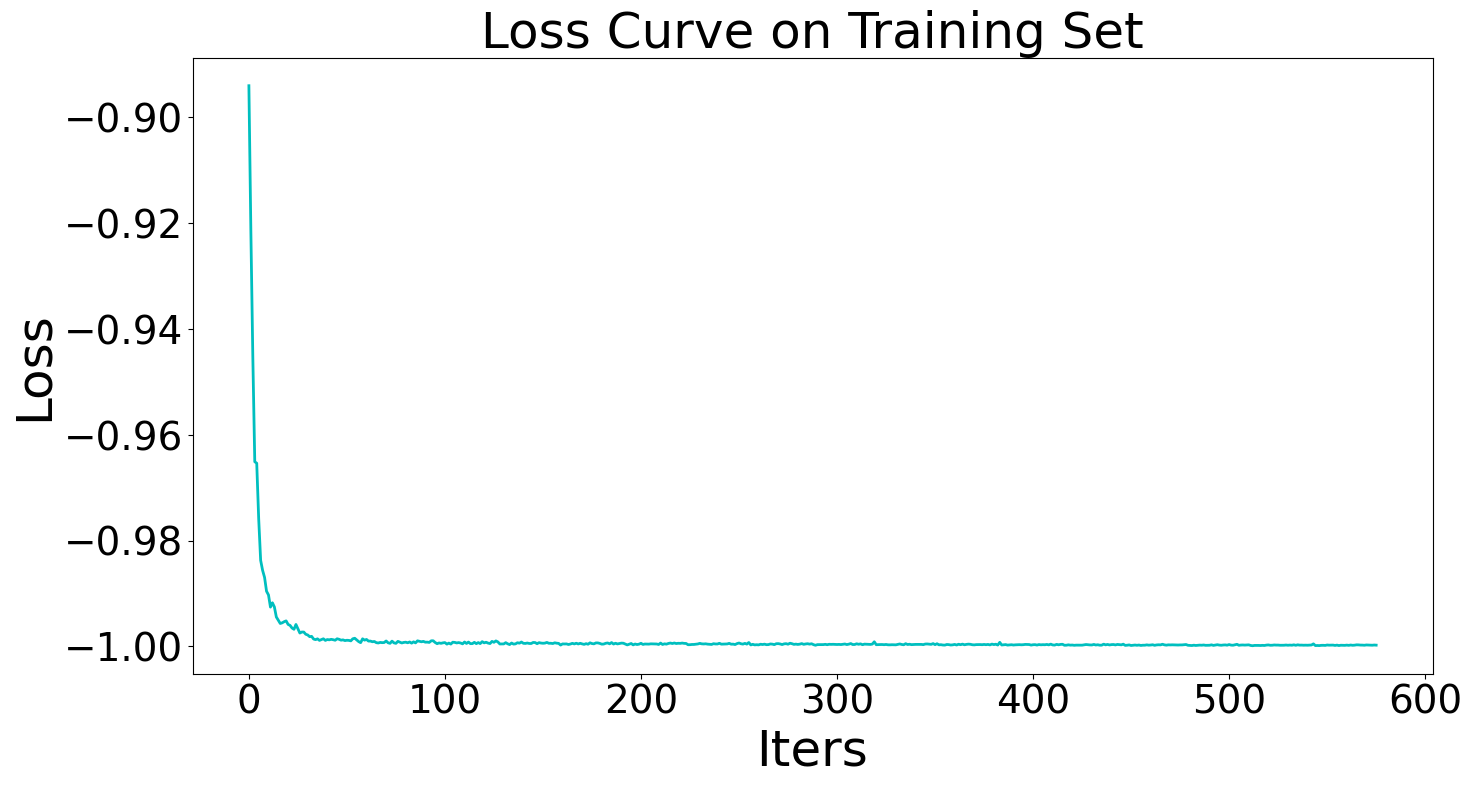

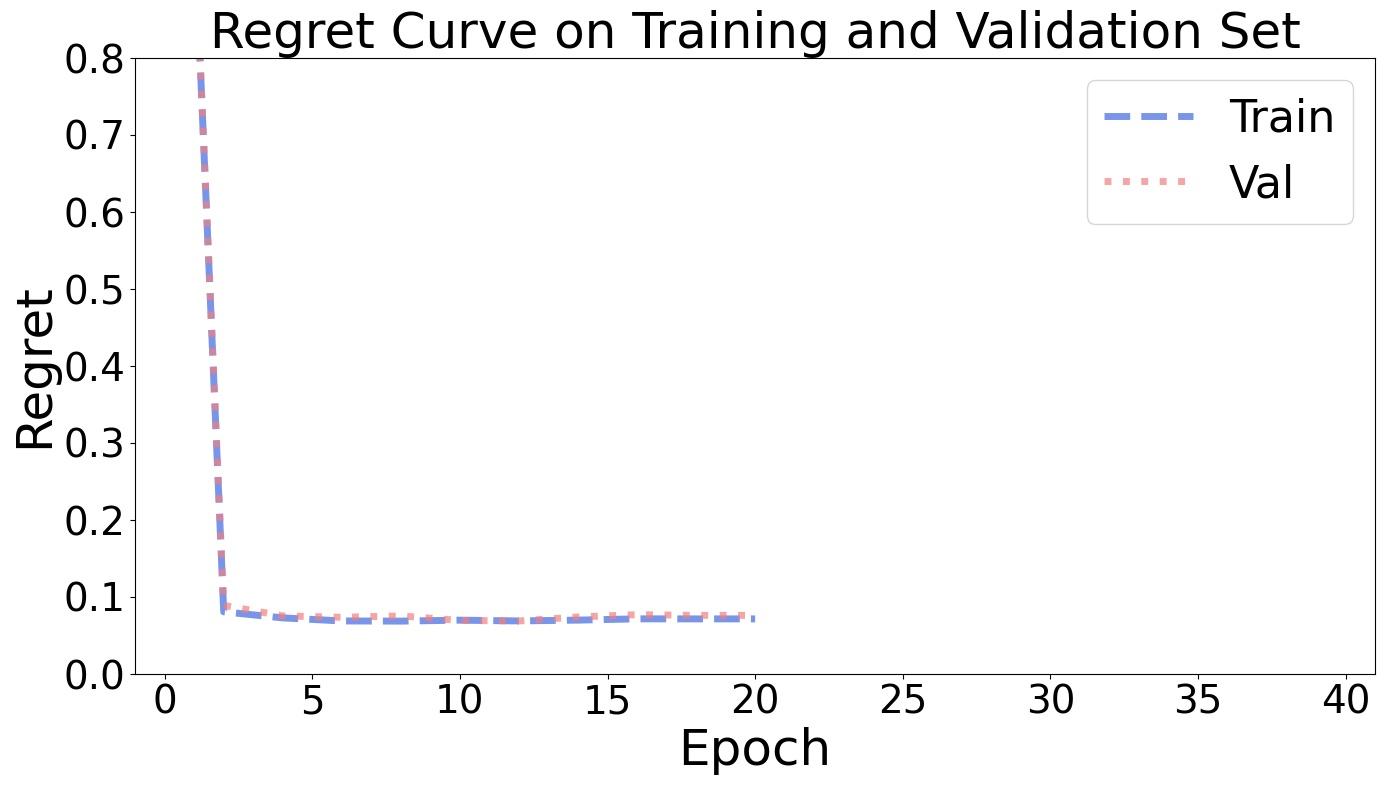

In [23]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [26]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:10<?, ?it/s]

Epoch   0, Train Regret: 186.8612%, Val Regret: 186.3438%


Epoch    1, Loss:  -0.7994:   5%|██▊                                                    | 2/40 [00:25<04:08,  6.54s/it]

Epoch   2, Train Regret:  16.1492%, Val Regret:  15.7691%


Epoch    3, Loss:  -0.7968:  10%|█████▌                                                 | 4/40 [00:40<03:51,  6.44s/it]

Epoch   4, Train Regret:  14.7794%, Val Regret:  15.8943%


Epoch    5, Loss:  -0.7985:  15%|████████▎                                              | 6/40 [00:55<03:40,  6.48s/it]

Epoch   6, Train Regret:  14.3181%, Val Regret:  16.3228%


Epoch    7, Loss:  -0.7436:  20%|███████████                                            | 8/40 [01:09<03:27,  6.47s/it]

Epoch   8, Train Regret:  14.3305%, Val Regret:  14.4439%


Epoch    9, Loss:  -0.7855:  25%|█████████████▌                                        | 10/40 [01:24<03:13,  6.46s/it]

Epoch  10, Train Regret:  14.0296%, Val Regret:  13.5923%


Epoch   11, Loss:  -0.7893:  30%|████████████████▏                                     | 12/40 [01:39<02:59,  6.42s/it]

Epoch  12, Train Regret:  14.3165%, Val Regret:  14.3748%


Epoch   13, Loss:  -0.7984:  35%|██████████████████▉                                   | 14/40 [01:53<02:45,  6.36s/it]

Epoch  14, Train Regret:  14.1007%, Val Regret:  14.7399%


Epoch   15, Loss:  -0.7891:  40%|█████████████████████▌                                | 16/40 [02:09<03:14,  8.09s/it]


Epoch  16, Train Regret:  13.8234%, Val Regret:  14.7009%
Early Stop!
Epoch  16, Loss:  -0.7891, Train Regret:  13.8234%, Val Regret:  14.7009%

Evaluation:
Test Regret: 14.3064%
Training Elapsed Time: 16.90 Sec


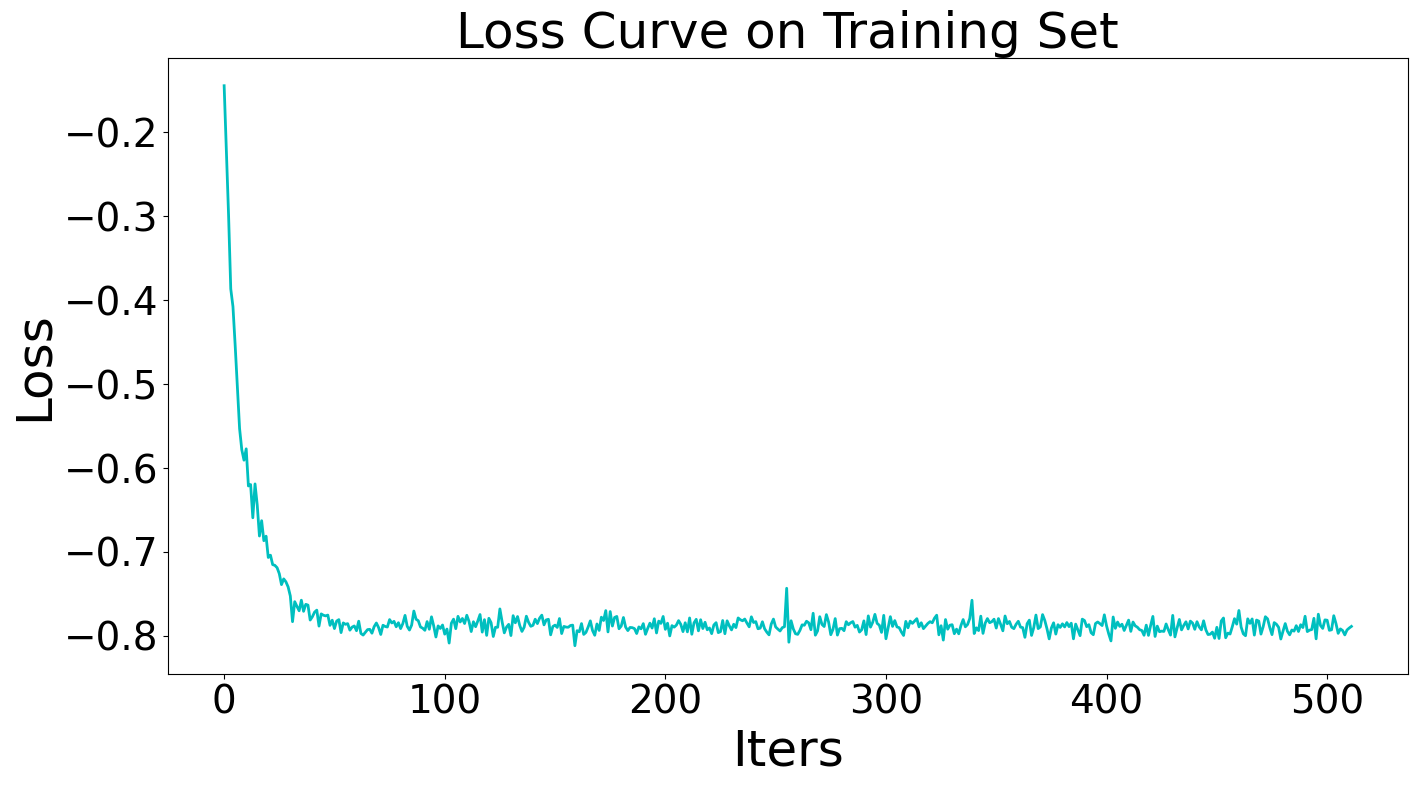

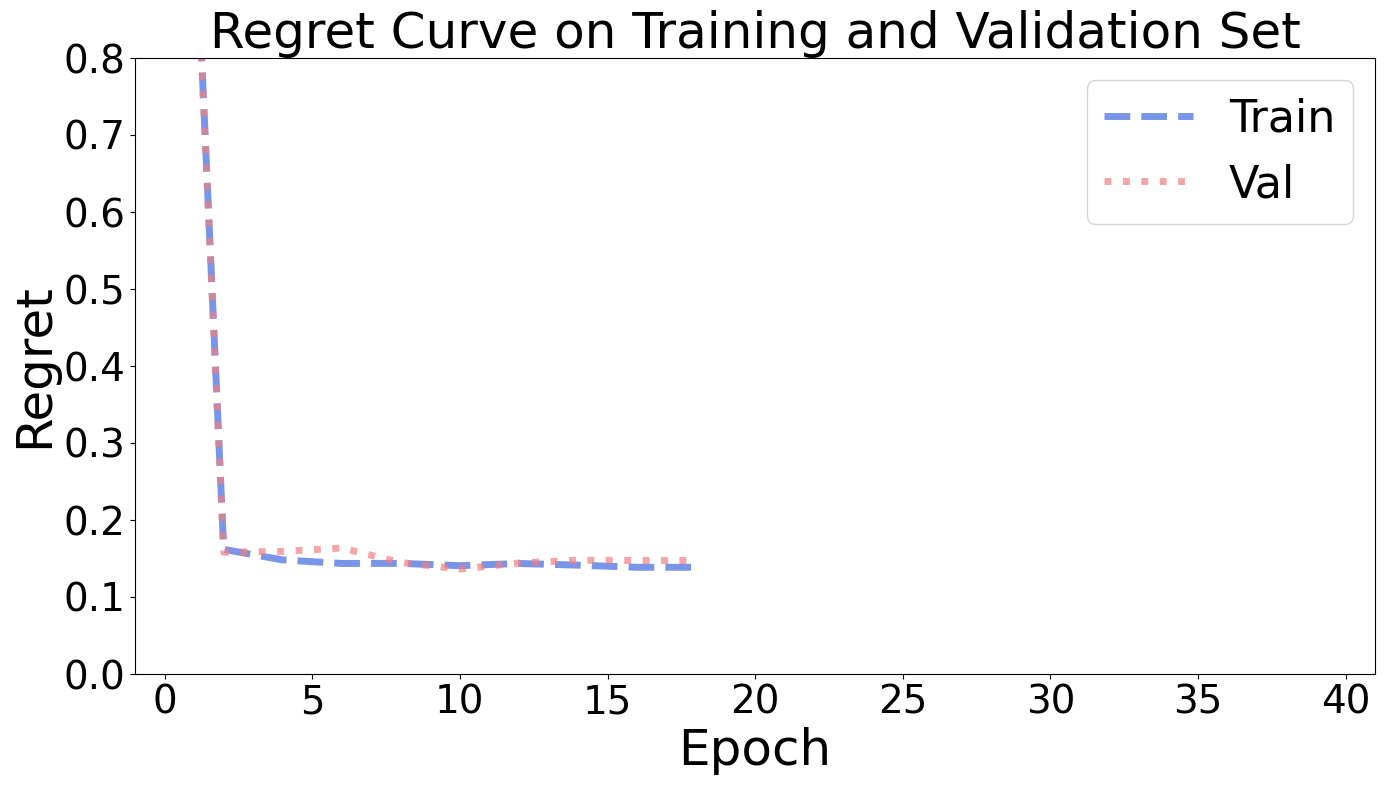

In [27]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

In [30]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:09<?, ?it/s]

Epoch   0, Train Regret: 209.1033%, Val Regret: 219.8416%


Epoch    1, Loss:  -0.8024:   5%|██▊                                                    | 2/40 [00:22<03:15,  5.15s/it]

Epoch   2, Train Regret:  14.0892%, Val Regret:  13.6827%


Epoch    3, Loss:  -0.7922:  10%|█████▌                                                 | 4/40 [00:35<03:14,  5.40s/it]

Epoch   4, Train Regret:  13.6740%, Val Regret:  14.5996%


Epoch    5, Loss:  -0.8361:  15%|████████▎                                              | 6/40 [00:48<03:07,  5.51s/it]

Epoch   6, Train Regret:  13.5639%, Val Regret:  14.3757%


Epoch    7, Loss:  -0.6839:  20%|███████████                                            | 8/40 [01:01<02:54,  5.46s/it]

Epoch   8, Train Regret:  13.3045%, Val Regret:  13.6655%


Epoch    9, Loss:  -0.7810:  25%|█████████████▌                                        | 10/40 [01:13<02:45,  5.50s/it]

Epoch  10, Train Regret:  13.3951%, Val Regret:  12.7630%


Epoch   11, Loss:  -0.8135:  30%|████████████████▏                                     | 12/40 [01:27<02:32,  5.45s/it]

Epoch  12, Train Regret:  13.8558%, Val Regret:  13.4915%


Epoch   13, Loss:  -0.7913:  35%|██████████████████▉                                   | 14/40 [01:41<02:25,  5.58s/it]

Epoch  14, Train Regret:  12.7296%, Val Regret:  13.7835%


Epoch   15, Loss:  -0.8171:  40%|█████████████████████▌                                | 16/40 [01:55<02:53,  7.23s/it]


Epoch  16, Train Regret:  12.9924%, Val Regret:  13.4734%
Early Stop!
Epoch  16, Loss:  -0.8171, Train Regret:  12.9924%, Val Regret:  13.4734%

Evaluation:
Test Regret: 13.9555%
Training Elapsed Time: 3.34 Sec


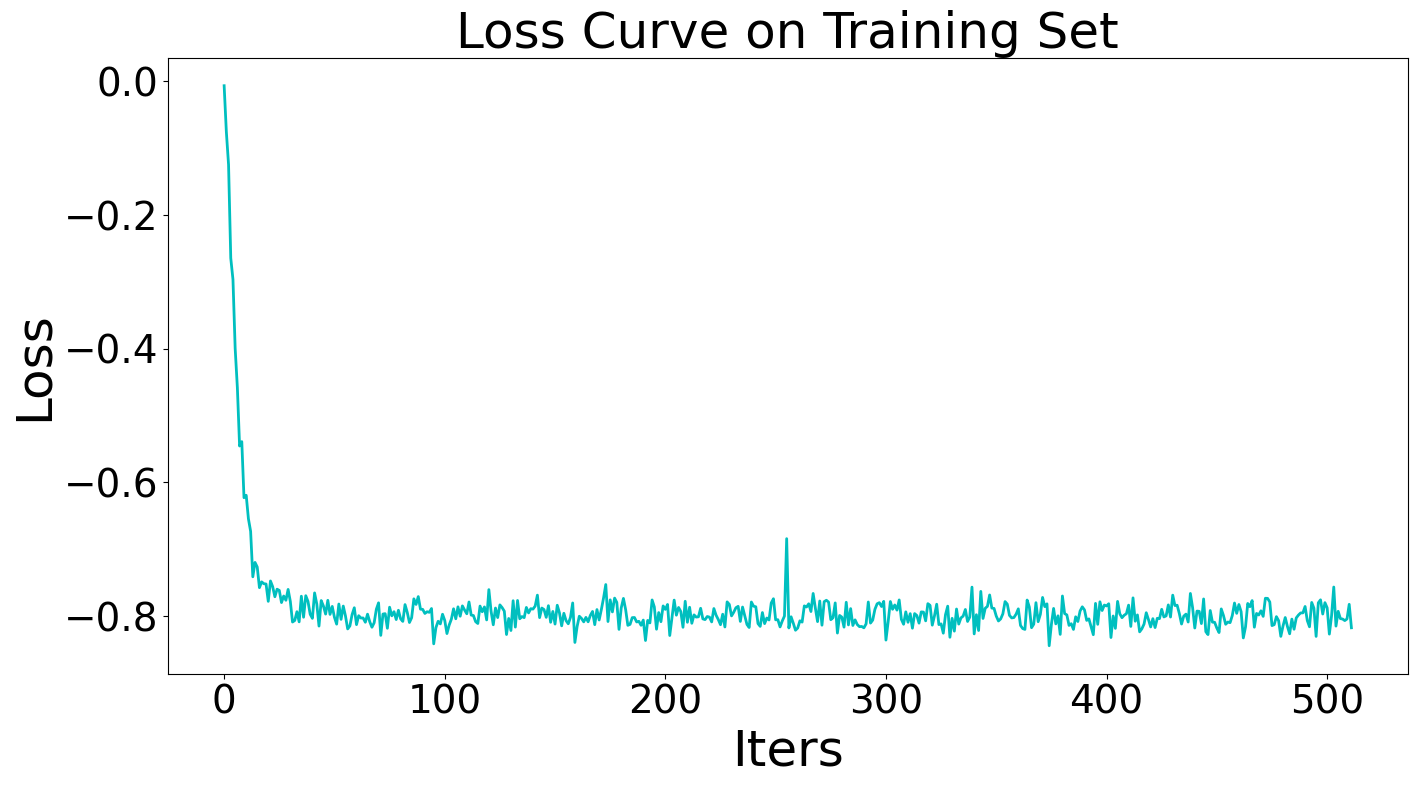

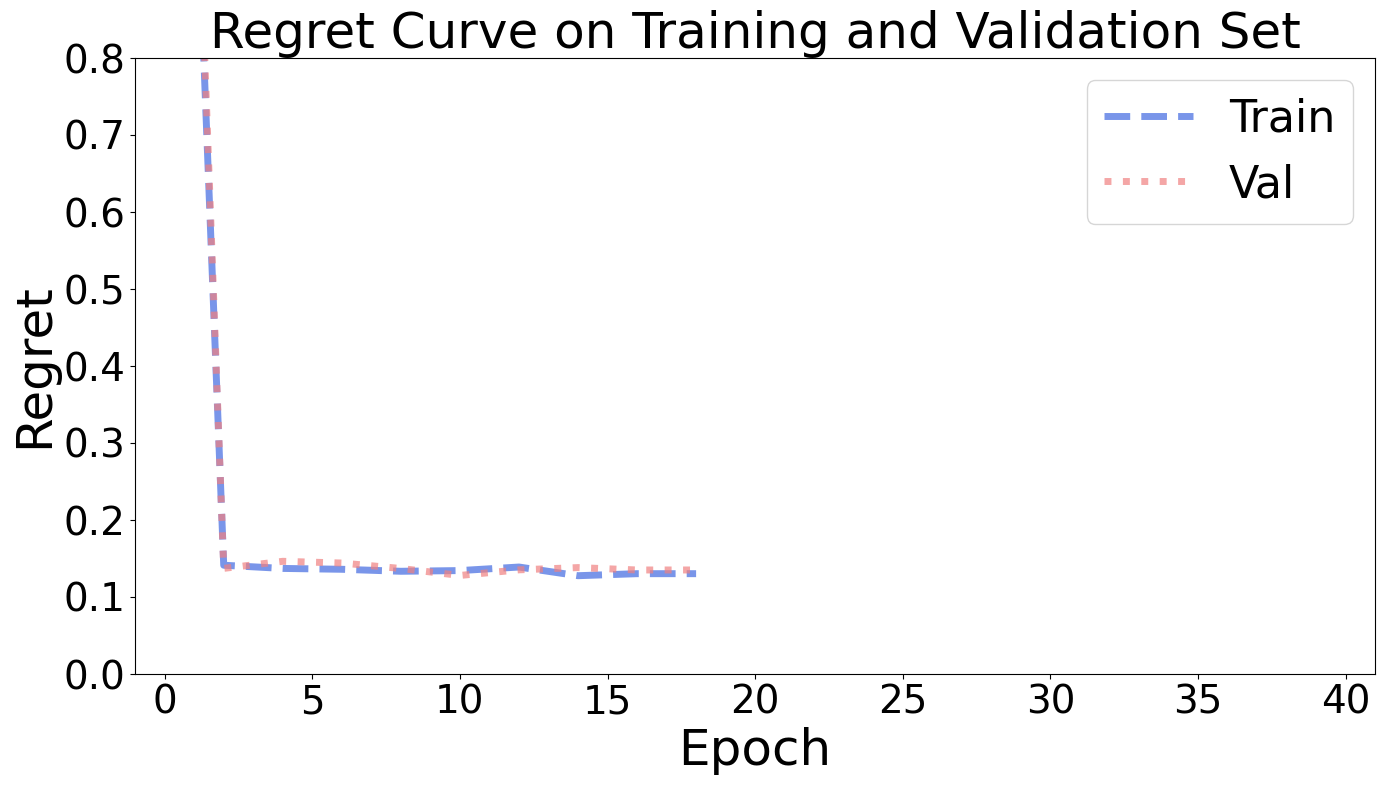

In [31]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sign Method 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import signConeAlignedCosine
# init loss
ca_cos = signConeAlignedCosine(optmodel)

In [34]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:09<?, ?it/s]

Epoch   0, Train Regret: 209.1033%, Val Regret: 219.8416%


Epoch    1, Loss:  -0.9947:   5%|██▊                                                    | 2/40 [00:22<03:20,  5.28s/it]

Epoch   2, Train Regret:  14.2990%, Val Regret:  15.4257%


Epoch    3, Loss:  -0.9958:  10%|█████▌                                                 | 4/40 [00:34<03:09,  5.27s/it]

Epoch   4, Train Regret:  13.9440%, Val Regret:  15.6541%


Epoch    5, Loss:  -0.9967:  15%|████████▎                                              | 6/40 [00:46<03:00,  5.30s/it]

Epoch   6, Train Regret:  14.1832%, Val Regret:  14.5593%


Epoch    7, Loss:  -0.9968:  20%|███████████                                            | 8/40 [00:59<02:49,  5.28s/it]

Epoch   8, Train Regret:  16.0876%, Val Regret:  19.8280%


Epoch    9, Loss:  -0.9960:  25%|█████████████▌                                        | 10/40 [01:12<02:39,  5.33s/it]

Epoch  10, Train Regret:  18.2040%, Val Regret:  21.0380%


Epoch   11, Loss:  -0.9977:  30%|████████████████▏                                     | 12/40 [01:26<03:21,  7.19s/it]


Epoch  12, Train Regret:  23.5899%, Val Regret:  26.2296%
Early Stop!
Epoch  12, Loss:  -0.9977, Train Regret:  23.5899%, Val Regret:  26.2296%

Evaluation:
Test Regret: 25.1485%
Training Elapsed Time: 2.71 Sec


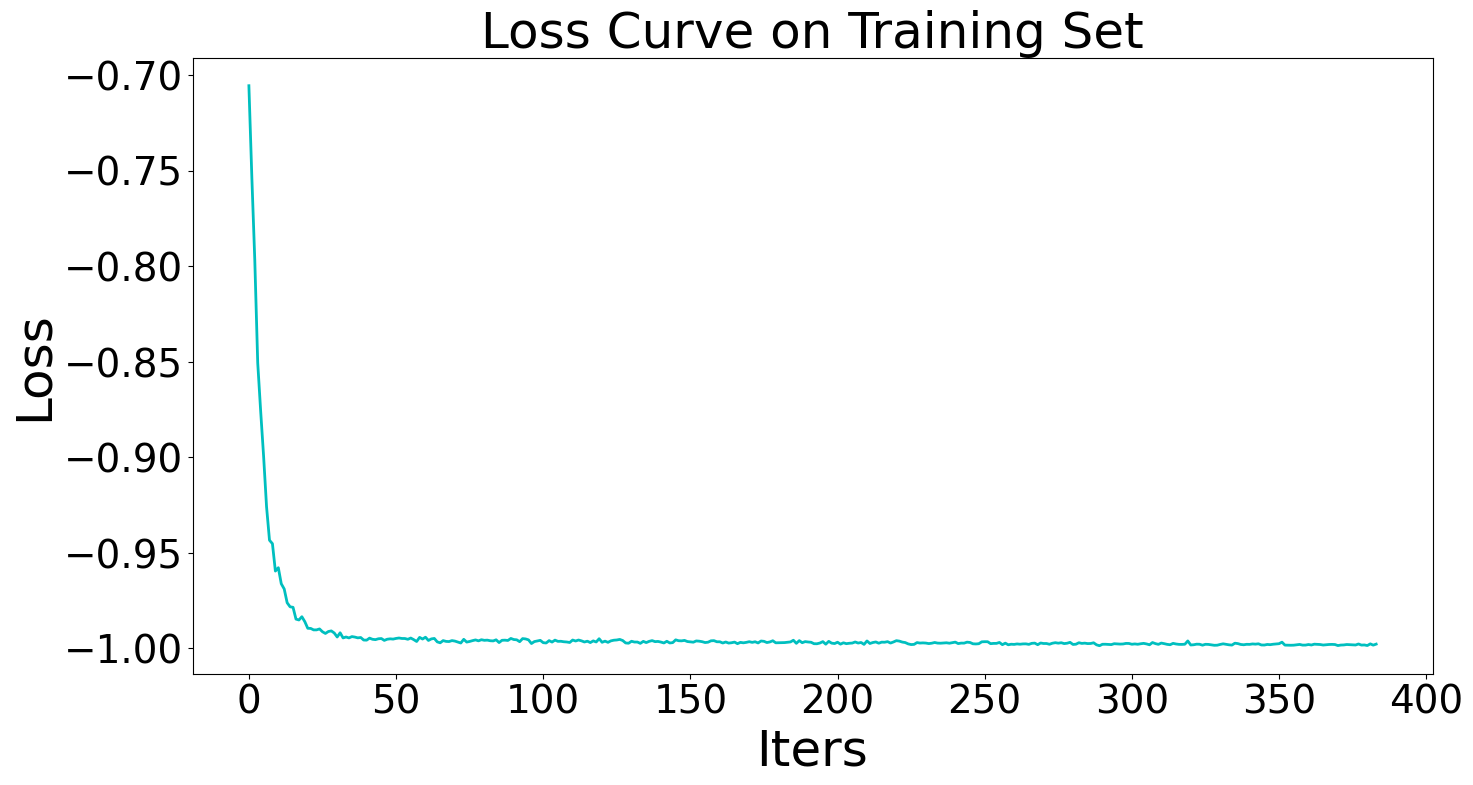

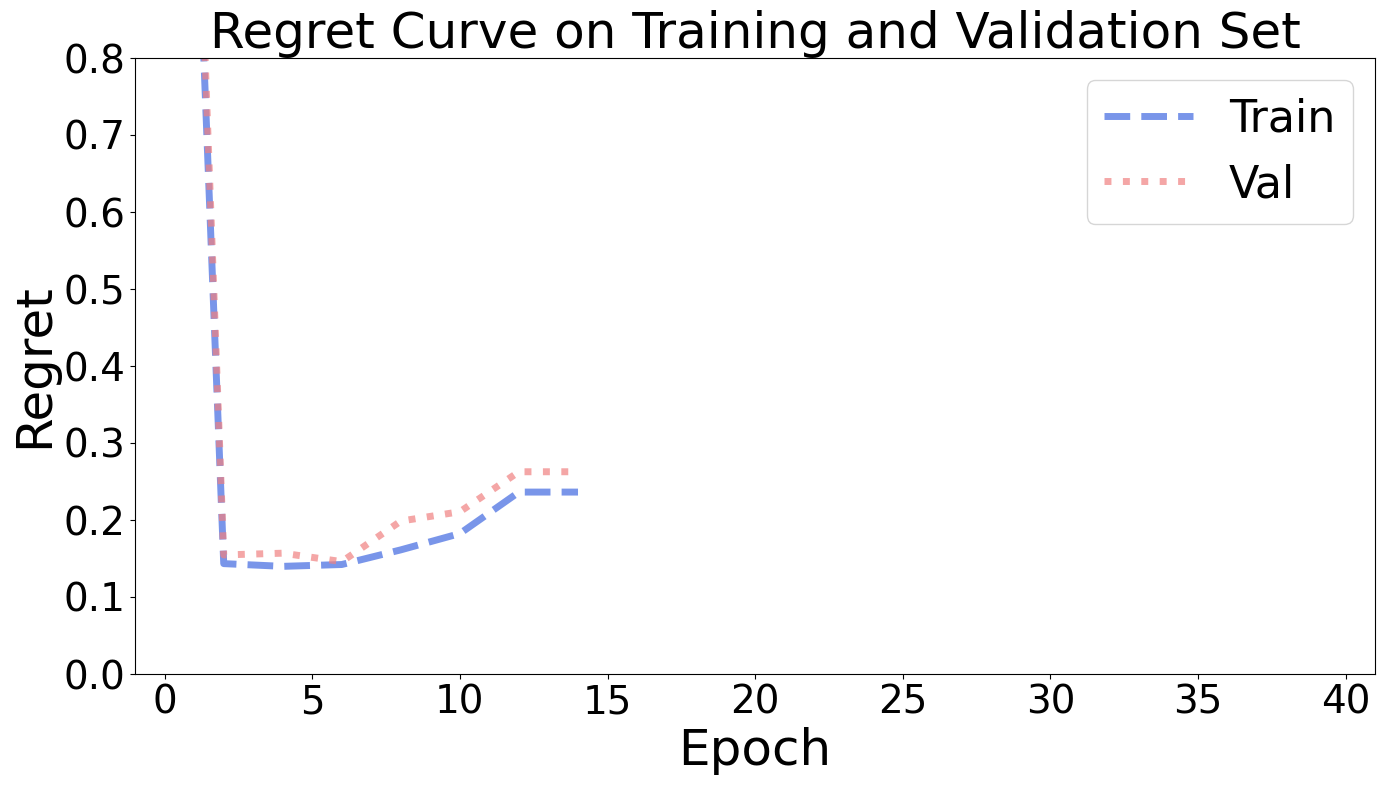

In [35]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [38]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:10<?, ?it/s]

Epoch   0, Train Regret: 210.3350%, Val Regret: 211.7011%


Epoch    1, Loss:  19.0000:   5%|██▊                                                    | 2/40 [00:29<05:23,  8.50s/it]

Epoch   2, Train Regret:   6.7692%, Val Regret:   7.6316%


Epoch    3, Loss:  17.2500:  10%|█████▌                                                 | 4/40 [00:49<05:14,  8.74s/it]

Epoch   4, Train Regret:   6.2514%, Val Regret:   7.4288%


Epoch    5, Loss:  16.5000:  15%|████████▎                                              | 6/40 [01:08<05:00,  8.83s/it]

Epoch   6, Train Regret:   6.1136%, Val Regret:   6.9506%


Epoch    7, Loss:  14.5000:  20%|███████████                                            | 8/40 [01:28<04:38,  8.70s/it]

Epoch   8, Train Regret:   5.9764%, Val Regret:   6.9942%


Epoch    9, Loss:  15.0000:  25%|█████████████▌                                        | 10/40 [01:48<04:24,  8.83s/it]

Epoch  10, Train Regret:   5.8445%, Val Regret:   6.7763%


Epoch   11, Loss:  15.2500:  30%|████████████████▏                                     | 12/40 [02:08<04:13,  9.05s/it]

Epoch  12, Train Regret:   5.7849%, Val Regret:   6.5178%


Epoch   13, Loss:  14.5000:  35%|██████████████████▉                                   | 14/40 [02:28<03:56,  9.10s/it]

Epoch  14, Train Regret:   5.5677%, Val Regret:   6.6121%


Epoch   15, Loss:  12.5000:  40%|█████████████████████▌                                | 16/40 [02:47<03:31,  8.82s/it]

Epoch  16, Train Regret:   5.6901%, Val Regret:   6.3891%


Epoch   17, Loss:  13.7500:  45%|████████████████████████▎                             | 18/40 [03:05<03:09,  8.61s/it]

Epoch  18, Train Regret:   5.7441%, Val Regret:   6.3651%


Epoch   19, Loss:  10.5000:  50%|███████████████████████████                           | 20/40 [03:25<02:49,  8.50s/it]

Epoch  20, Train Regret:   5.7656%, Val Regret:   5.9111%


Epoch   21, Loss:  16.2500:  55%|█████████████████████████████▋                        | 22/40 [03:44<02:36,  8.72s/it]

Epoch  22, Train Regret:   6.0328%, Val Regret:   6.8889%


Epoch   23, Loss:  17.7500:  60%|████████████████████████████████▍                     | 24/40 [04:06<02:24,  9.00s/it]

Epoch  24, Train Regret:   5.7174%, Val Regret:   6.2874%


Epoch   25, Loss:  15.2500:  65%|███████████████████████████████████                   | 26/40 [04:24<02:22, 10.18s/it]


Epoch  26, Train Regret:   5.6653%, Val Regret:   6.2212%
Early Stop!
Epoch  26, Loss:  15.2500, Train Regret:   5.6653%, Val Regret:   6.2212%

Evaluation:
Test Regret: 6.3898%
Training Elapsed Time: 86.13 Sec


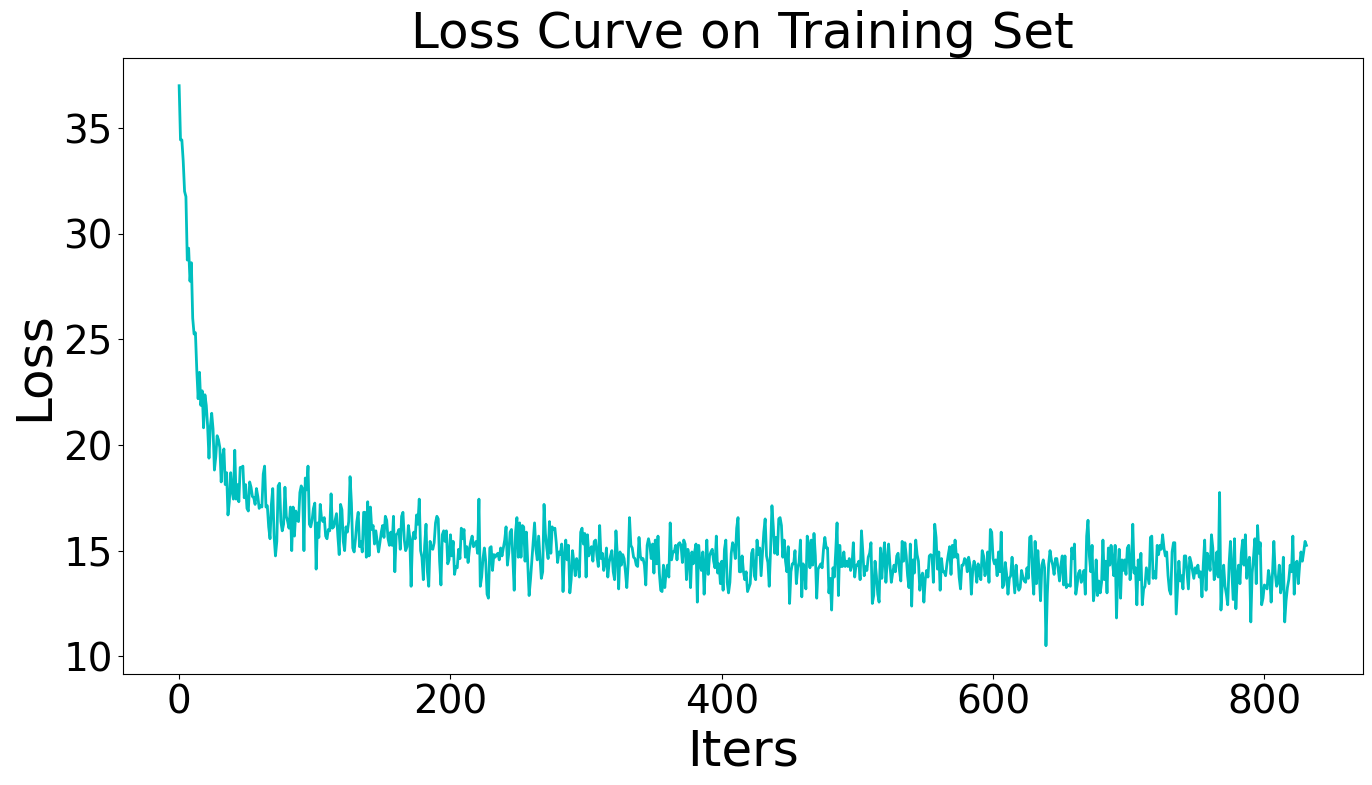

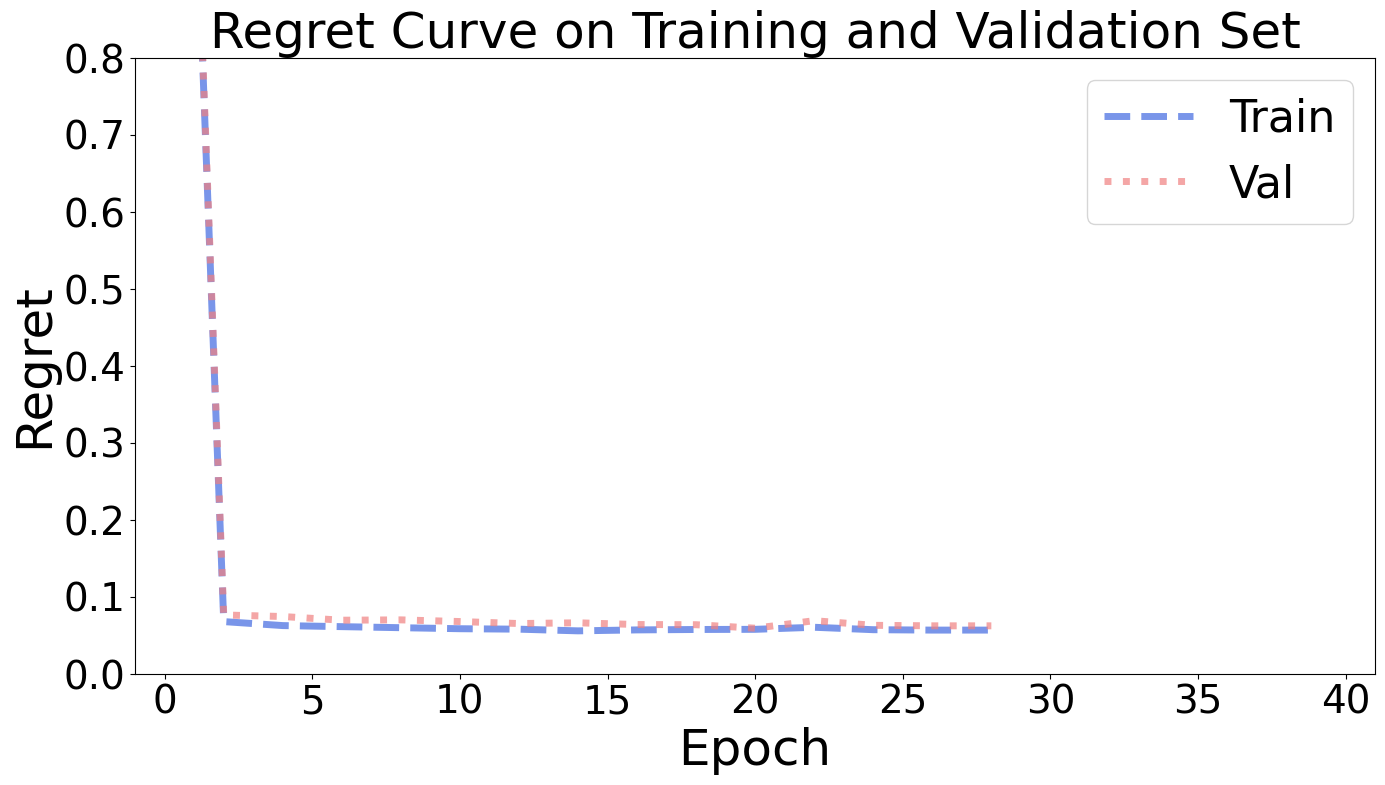

In [39]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [40]:
# init model
reg = LinearRegression()

In [41]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 2


In [42]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:10<?, ?it/s]

Epoch   0, Train Regret: 198.2019%, Val Regret: 210.7036%


Epoch    1, Loss: -117.9454:   5%|██▋                                                   | 2/40 [00:29<04:55,  7.78s/it]

Epoch   2, Train Regret:  15.2791%, Val Regret:  17.1244%


Epoch    3, Loss: -244.0517:  10%|█████▍                                                | 4/40 [00:42<04:00,  6.68s/it]

Epoch   4, Train Regret:  13.9178%, Val Regret:  14.5759%


Epoch    5, Loss: -487.4118:  15%|████████                                              | 6/40 [00:57<03:37,  6.39s/it]

Epoch   6, Train Regret:  12.9772%, Val Regret:  14.5104%


Epoch    7, Loss: -492.5230:  20%|██████████▊                                           | 8/40 [01:12<03:22,  6.33s/it]

Epoch   8, Train Regret:  12.5744%, Val Regret:  14.3494%


Epoch    9, Loss: -615.9519:  25%|█████████████▎                                       | 10/40 [01:25<03:11,  6.39s/it]

Epoch  10, Train Regret:  12.1894%, Val Regret:  14.1544%


Epoch   11, Loss: -756.2512:  30%|███████████████▉                                     | 12/40 [01:39<02:53,  6.20s/it]

Epoch  12, Train Regret:  11.8709%, Val Regret:  13.3707%


Epoch   13, Loss: -1022.3876:  35%|██████████████████▏                                 | 14/40 [01:51<02:29,  5.74s/it]

Epoch  14, Train Regret:  11.5571%, Val Regret:  12.9155%


Epoch   15, Loss: -1011.3539:  40%|████████████████████▊                               | 16/40 [02:04<02:17,  5.73s/it]

Epoch  16, Train Regret:  11.4120%, Val Regret:  12.8972%


Epoch   17, Loss: -1178.4302:  45%|███████████████████████▍                            | 18/40 [02:19<02:06,  5.76s/it]

Epoch  18, Train Regret:  11.2257%, Val Regret:  12.6727%


Epoch   19, Loss: -1436.1952:  50%|██████████████████████████                          | 20/40 [02:33<02:01,  6.07s/it]

Epoch  20, Train Regret:  11.0251%, Val Regret:  12.5451%


Epoch   21, Loss: -1386.0332:  55%|████████████████████████████▌                       | 22/40 [02:47<01:45,  5.87s/it]

Epoch  22, Train Regret:  10.9822%, Val Regret:  12.4871%


Epoch   23, Loss: -1358.1411:  60%|███████████████████████████████▏                    | 24/40 [03:01<01:34,  5.91s/it]

Epoch  24, Train Regret:  10.9321%, Val Regret:  12.4543%


Epoch   25, Loss: -1896.0203:  65%|█████████████████████████████████▊                  | 26/40 [03:14<01:25,  6.08s/it]

Epoch  26, Train Regret:  10.8824%, Val Regret:  12.2467%


Epoch   27, Loss: -1978.0323:  70%|████████████████████████████████████▍               | 28/40 [03:28<01:12,  6.02s/it]

Epoch  28, Train Regret:  10.8149%, Val Regret:  11.9527%


Epoch   29, Loss: -2062.9983:  75%|███████████████████████████████████████             | 30/40 [03:41<01:00,  6.00s/it]

Epoch  30, Train Regret:  10.7105%, Val Regret:  11.7530%


Epoch   31, Loss: -1767.6429:  80%|█████████████████████████████████████████▌          | 32/40 [03:55<00:46,  5.81s/it]

Epoch  32, Train Regret:  10.6898%, Val Regret:  11.8477%


Epoch   33, Loss: -2355.4270:  85%|████████████████████████████████████████████▏       | 34/40 [04:08<00:35,  5.90s/it]

Epoch  34, Train Regret:  10.6531%, Val Regret:  11.7329%


Epoch   35, Loss: -2187.2947:  90%|██████████████████████████████████████████████▊     | 36/40 [04:21<00:22,  5.59s/it]

Epoch  36, Train Regret:  10.6352%, Val Regret:  11.7495%


Epoch   37, Loss: -2278.0845:  95%|█████████████████████████████████████████████████▍  | 38/40 [04:34<00:11,  5.79s/it]

Epoch  38, Train Regret:  10.5595%, Val Regret:  11.7601%


Epoch   39, Loss: -2865.8623: 100%|████████████████████████████████████████████████████| 40/40 [04:38<00:00,  6.95s/it]


Epoch  39, Loss: -2865.8623, Train Regret:  10.5750%, Val Regret:  11.8723%

Evaluation:
Test Regret: 11.5136%
Training Elapsed Time: 31.15 Sec


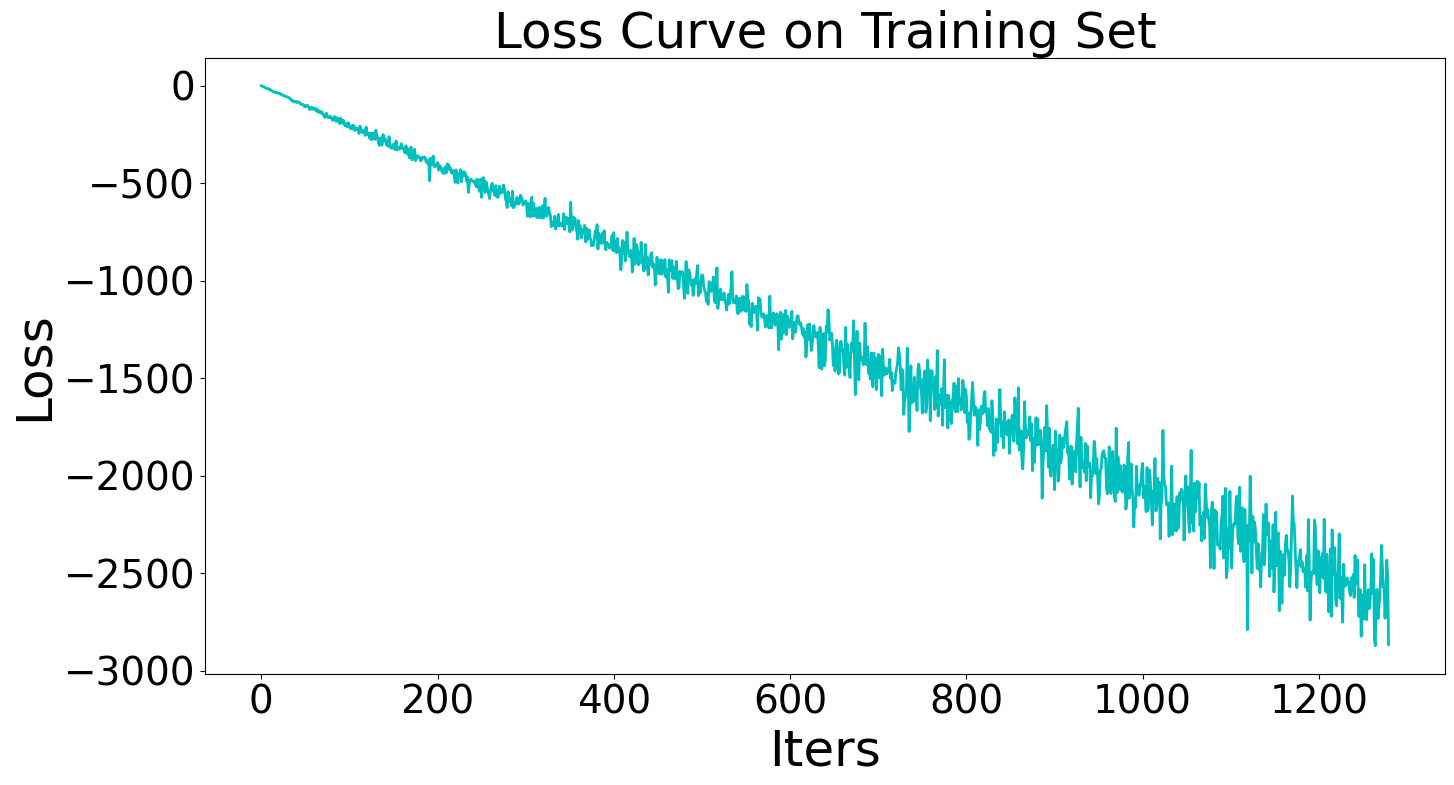

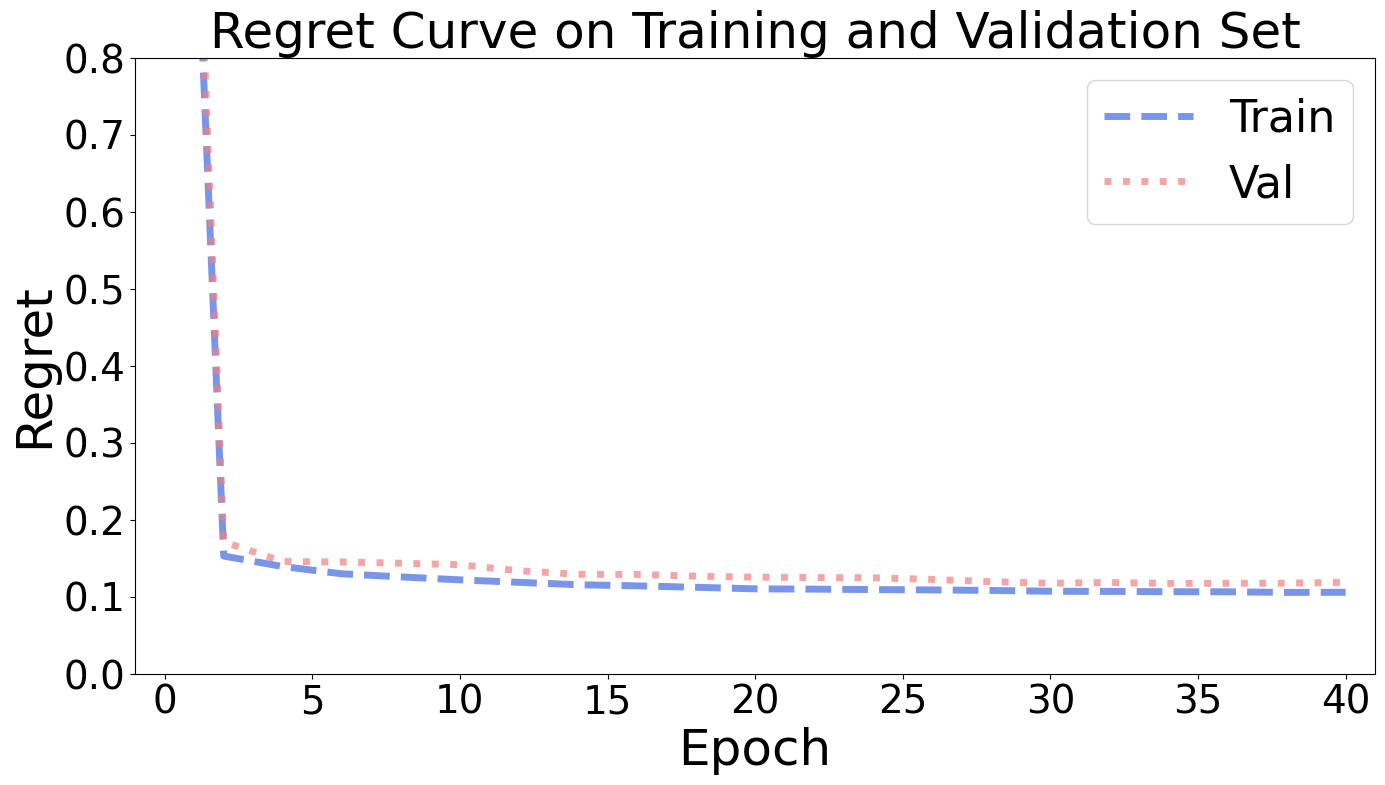

In [43]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)